In [2]:
from google.colab import files
files.upload()

Saving kaggle (1).json to kaggle (1).json


{'kaggle (1).json': b'{"username":"asthashinde0","key":"c556574bdf5316bba0f3d6438c301bb8"}'}

In [3]:
!pip install kaggle
import os

os.makedirs('/root/.kaggle', exist_ok=True)
!mv 'kaggle (1).json' /root/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d azizkasimov/wind-turbine-scada-data-for-early-fault-detection

Dataset URL: https://www.kaggle.com/datasets/azizkasimov/wind-turbine-scada-data-for-early-fault-detection
License(s): CC-BY-SA-4.0
100% 5.81G/5.82G [01:07<00:00, 154MB/s]
100% 5.82G/5.82G [01:07<00:00, 92.7MB/s]


In [4]:
!unzip wind-turbine-scada-data-for-early-fault-detection.zip

Archive:  wind-turbine-scada-data-for-early-fault-detection.zip
replace README.md? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [5]:
import os

print("Files and Folders in /content:")
print(os.listdir("/content"))

Files and Folders in /content:
['.config', 'Wind Farm C', 'autoencoder_model.h5', 'README.txt', 'Wind Farm A', 'processed_wind_farm_a.csv', 'README.md', 'wind-turbine-scada-data-for-early-fault-detection.zip', 'Wind Farm B', 'sample_data']


In [6]:
import os
import pandas as pd
import glob

base_path = "/content"


def load_data(folder_name):
    folder_path = os.path.join(base_path, folder_name)
    all_files = glob.glob(os.path.join(folder_path, "*.csv"))
    df_list = [pd.read_csv(file) for file in all_files]
    return pd.concat(df_list, ignore_index=True)

df_a = load_data("Wind Farm A")
df_b = load_data("Wind Farm B")
df_c = load_data("Wind Farm C")

df = pd.concat([df_a, df_b, df_c], ignore_index=True)

print(df.head())
print(df.info())


    sensor_name                  statistics_type              description  \
0      sensor_0                          average      Ambient temperature   
1      sensor_1                          average  Wind absolute direction   
2      sensor_2                          average  Wind relative direction   
3  wind_speed_3  maximum,minimum,average,std_dev                Windspeed   
4  wind_speed_4                          average      Estimated windspeed   

  unit is_angle is_counter  event_id event_label event_start  event_start_id  \
0   �C    False      False       NaN         NaN         NaN             NaN   
1    �     True      False       NaN         NaN         NaN             NaN   
2    �     True      False       NaN         NaN         NaN             NaN   
3  m/s    False      False       NaN         NaN         NaN             NaN   
4  m/s    False      False       NaN         NaN         NaN             NaN   

  event_end  event_end_id event_description  
0       Na

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


df_cleaned = df.drop(columns=['event_id', 'event_label', 'event_start', 'event_start_id',
                              'event_end', 'event_end_id', 'event_description'])



In [8]:
#missing values filled with unknown
df_cleaned.fillna({'unit': 'Unknown', 'statistics_type': 'Unknown', 'description': 'Unknown'}, inplace=True)

#checking if missing values handled
print(df_cleaned.isnull().sum())


sensor_name        95
statistics_type     0
description         0
unit                0
is_angle           95
is_counter         95
dtype: int64


In [9]:
df_cleaned['sensor_name'].fillna('Unknown', inplace=True)
df_cleaned['is_angle'] = df_cleaned['is_angle'].map({'True': 1, 'False': 0})
df_cleaned['is_counter'] = df_cleaned['is_counter'].map({'True': 1, 'False': 0})

<ipython-input-9-93519bdd6faf>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['sensor_name'].fillna('Unknown', inplace=True)


In [10]:

df_cleaned[['is_angle', 'is_counter']] = df_cleaned[['is_angle', 'is_counter']].fillna(0)


In [11]:
print(df_cleaned.isnull().sum())

sensor_name        0
statistics_type    0
description        0
unit               0
is_angle           0
is_counter         0
dtype: int64


In [12]:
from sklearn.preprocessing import LabelEncoder
categorical_cols = ['sensor_name', 'statistics_type', 'description', 'unit']


In [13]:
#Label Encoding
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_cleaned[col] = le.fit_transform(df_cleaned[col])
    label_encoders[col] = le  # Save encoder

print(df_cleaned.head())

   sensor_name  statistics_type  description  unit  is_angle  is_counter
0           16                1           22    32       0.0         0.0
1           17                1          337    31       0.0         0.0
2          124                1          338    31       0.0         0.0
3          250               10          344    24       0.0         0.0
4          251                1           88    24       0.0         0.0


In [14]:
numerical_cols = ['is_angle', 'is_counter']

# Standardizing
scaler = StandardScaler()
df_cleaned[numerical_cols] = scaler.fit_transform(df_cleaned[numerical_cols])

# scaling
print(df_cleaned.describe())


       sensor_name  statistics_type  description        unit  is_angle  \
count   450.000000       450.000000   450.000000  450.000000     450.0   
mean    106.417778         4.457778   205.337778   12.024444       0.0   
std      83.145316         5.406360   108.688380    9.898227       0.0   
min       0.000000         0.000000     0.000000    0.000000       0.0   
25%      16.250000         1.000000   111.250000    3.000000       0.0   
50%     110.500000         2.000000   218.500000   10.000000       0.0   
75%     181.750000         6.000000   327.000000   15.000000       0.0   
max     254.000000        23.000000   345.000000   32.000000       0.0   

       is_counter  
count       450.0  
mean          0.0  
std           0.0  
min           0.0  
25%           0.0  
50%           0.0  
75%           0.0  
max           0.0  


In [15]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Select features for training
features = ['sensor_name', 'statistics_type', 'description', 'unit']
X_train = df_cleaned[features].values

# Normalize  input data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Autoencoder architecture
input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
encoded = Dense(4, activation='relu')(encoded)

decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(decoded)
decoded = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Training autoencoder
history = autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Saving train model
autoencoder.save("autoencoder_model.h5")


Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 1.0020 - val_loss: 0.9952
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.8965 - val_loss: 0.9666
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.9179 - val_loss: 0.9255
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8421 - val_loss: 0.8552
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.8248 - val_loss: 0.8104
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7633 - val_loss: 0.7559
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.7577 - val_loss: 0.6860
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.7272 - val_loss: 0.6105
Epoch 9/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.6946 - val_loss: 0.5378
Epoch 10/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.7083 - val_loss: 0.4733
Epoch 11/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.6739 - val_loss: 0.4093
Epoch 12/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.68

In [16]:
X_train_pred = autoencoder.predict(X_train)

# MSE
mse = np.mean(np.power(X_train - X_train_pred, 2), axis=1)

# threshold 4 anomaly detection - 95th percent
threshold = np.percentile(mse, 95)

# Identify anomalies
anomalies = mse > threshold

df_cleaned['Anomaly'] = anomalies.astype(int)

# Checking anomalies
print(df_cleaned[['sensor_name', 'Anomaly']].head(20))


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
    sensor_name  Anomaly
0            16        1
1            17        0
2           124        0
3           250        0
4           251        0
5           192        0
6           203        0
7           214        0
8           225        0
9           236        0
10           18        0
11           29        0
12           39        0
13           47        0
14           58        0
15           69        0
16           80        0
17           91        0
18          102        0
19          113        0


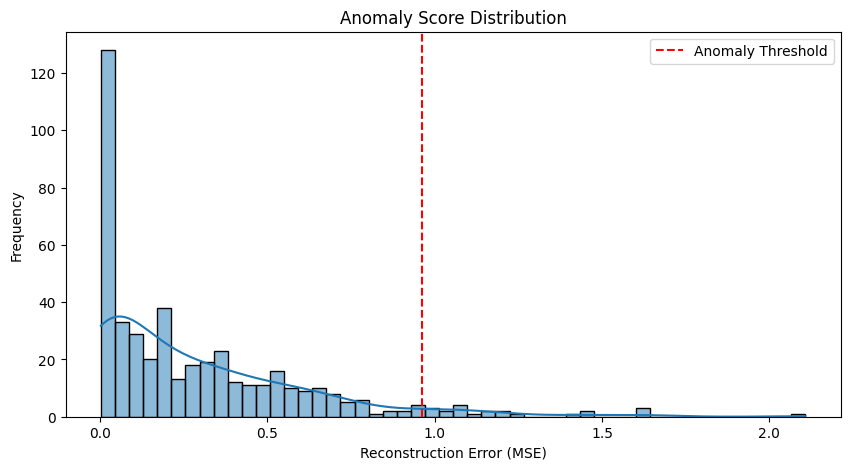

In [17]:
plt.figure(figsize=(10,5))
sns.histplot(mse, bins=50, kde=True)
plt.axvline(threshold, color='red', linestyle='dashed', label='Anomaly Threshold')
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.title("Anomaly Score Distribution")
plt.legend()
plt.show()

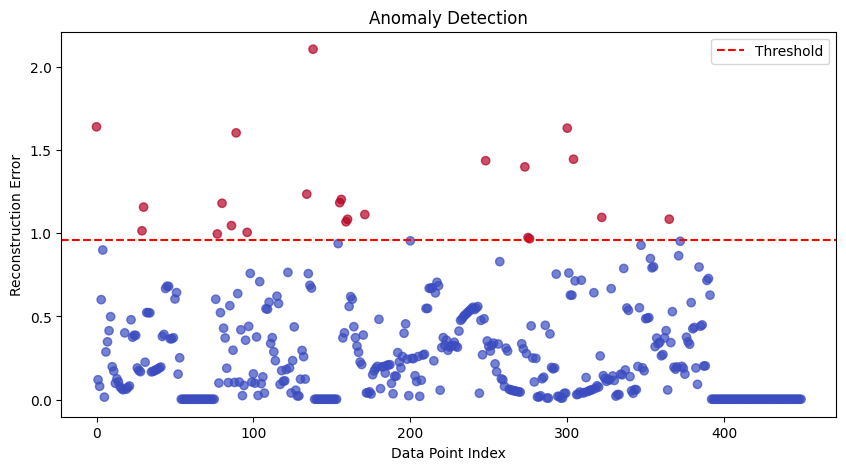

In [18]:
plt.figure(figsize=(10,5))
plt.scatter(range(len(mse)), mse, c=anomalies, cmap='coolwarm', alpha=0.7)
plt.axhline(threshold, color='red', linestyle='dashed', label='Threshold')
plt.xlabel("Data Point Index")
plt.ylabel("Reconstruction Error")
plt.title("Anomaly Detection")
plt.legend()
plt.show()

In [19]:
import os

data_path = "/content/Wind Farm A/datasets"

dfs = []
for file in os.listdir(data_path):
    if file.endswith(".csv"):
        file_path = os.path.join(data_path, file)

        df = pd.read_csv(file_path, engine="python", on_bad_lines='skip')

        df['time_stamp'] = pd.to_datetime(df['time_stamp'], errors='coerce')

        df = df.sort_values(by='time_stamp')

        dfs.append(df)

df_a = pd.concat(dfs, ignore_index=True)

df_a = df_a.select_dtypes(include=['number'])

df_a.fillna(method='ffill', inplace=True) #missing

df_a.to_csv("/content/processed_wind_farm_a.csv", index=False) #saves

print("Wind Farm A processed. Moving to model training")


<ipython-input-19-3a04ffe520bd>:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_a.fillna(method='ffill', inplace=True) #missing


Wind Farm A processed. Moving to model training


Preparing Data For RNN

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
df = pd.read_csv("/content/processed_wind_farm_a.csv")

df = df.sample(frac=0.4, random_state=42)

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled = df_scaled.sort_index()

print(f" {df_scaled.shape[0]} ")


 478699 


As their were time constraints and the dataset was too large , we only used 40% of our dataset and accordingly scaled it

In [15]:
import numpy as np
sequence_length = 10

# Function to create sequences for RNN
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i : i + seq_length])  # Past observ
        y.append(data[i + seq_length])  #prediction
    return np.array(X), np.array(y)

X, y = create_sequences(df_scaled.values, sequence_length)

#X, y = X[:5000], y[:5000]

# train & test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f"Training dataset size: {X_train.shape}, Testing dataset size: {X_test.shape}")


Training dataset size: (382951, 10, 84), Testing dataset size: (95738, 10, 84)


In [17]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense

# RNN model
model = Sequential([
    SimpleRNN(32, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
    SimpleRNN(16, return_sequences=False),
    Dense(X_train.shape[2], activation='linear')
])

model.compile(optimizer='adam', loss='mse')

model.fit(X_train, y_train, epochs=5, batch_size=16, validation_data=(X_test, y_test))

print(" RNN Model Training Completed")

Epoch 1/5
23935/23935 ━━━━━━━━━━━━━━━━━━━━ 178s 7ms/step - loss: 0.0544 - val_loss: 0.0522
Epoch 2/5
23935/23935 ━━━━━━━━━━━━━━━━━━━━ 214s 8ms/step - loss: 0.0521 - val_loss: 0.0521
Epoch 3/5
23935/23935 ━━━━━━━━━━━━━━━━━━━━ 198s 8ms/step - loss: 0.0520 - val_loss: 0.0521
Epoch 4/5
23935/23935 ━━━━━━━━━━━━━━━━━━━━ 200s 8ms/step - loss: 0.0520 - val_loss: 0.0521
Epoch 5/5
23935/23935 ━━━━━━━━━━━━━━━━━━━━ 192s 7ms/step - loss: 0.0520 - val_loss: 0.0521
 RNN Model Training Completed


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

y_pred = model.predict(X_test)

#MAE & MSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print(f"Model Evaluate :MAE = {mae:.4f}, MSE = {mse:.4f}")


2992/2992 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step
Model Evaluate :MAE = 0.1617, MSE = 0.0521


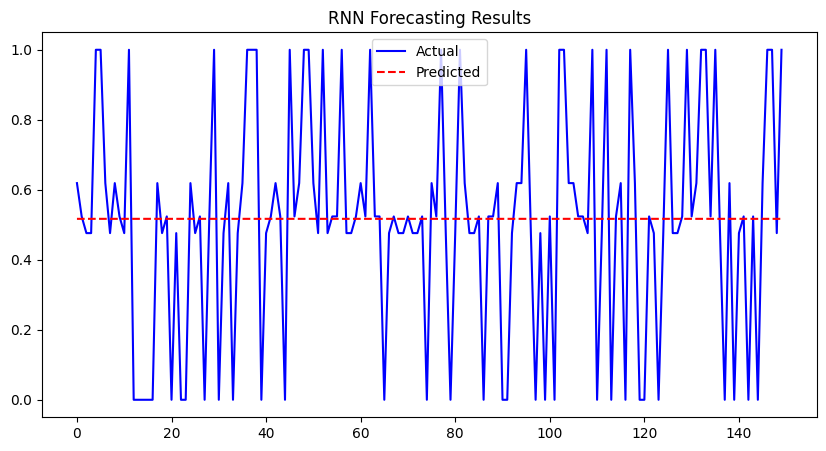

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test[:150, 0], label="Actual", color="blue")
plt.plot(y_pred[:150, 0], label="Predicted", color="red", linestyle="dashed")
plt.legend()
plt.title("RNN Forecasting Results")
plt.show()

As we significantly reduced the dataset for faster training , therefore theirs a huge gap between predicted and actual values.The model didn’t get enough data to learn patterns properly.  But with more runtime , the results would be better.

In [25]:
print("Min and Max of y_test:", y_test.min(), y_test.max())
print("Min and Max of y_pred:", y_pred.min(), y_pred.max())


Min and Max of y_test: 0.0 1.0
Min and Max of y_pred: -0.009746517 0.9993801
